# IMPORT SECTION

In [ ]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord
import os
from tqdm import tqdm
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
%load_ext tensorboard 
from tensorboard import notebook
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

     |████████████████████████████████| 19.3MB 165kB/s 
  Created wheel for music21: filename=music21-6.7.1-cp37-none-any.whl size=21941694 sha256=1229d38055d08c84399d18697e0d84fd0c546248913c443a33ac0b89c7f1f255
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MIDI_PATH="/content/drive/My Drive/MLFolder/Onlab/MIDI_Iron_Maiden/"

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Feb 27 19:14:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UTILITY FUNCTIONS SECTION

In [ ]:
#https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

def most_frequent(paramlist): 
    counter = 0
    num = paramlist[0] 
      
    for i in paramlist: 
        curr_frequency = paramlist.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

#Utility functions

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def create_mapper(chords):
    pitchnames = sorted(set(str(item) for item in chords))
    mapper = dict((note, number) for number, note in enumerate(pitchnames))

    return mapper

def encode_using_mapper(chords, mapper):
    encodedsong=[]
    for c in chords:
        encodedsong.append(mapper[str(c)])

    return encodedsong


def decode_chords_using_mapper(numbers, mapper):
    outputnotes = []
    for number in numbers:
        outputnotes.append(chord_from_string(get_notes_from_chord(get_key_from_value(number, mapper))))

    return outputnotes

def combine_chords_with_durations(chords, durations):
    combined = []

    for i, j in zip(chords, durations):
        i = get_notes_from_chord(str(i))
        j = get_number_from_duration(str(j))
        combined.append(i + ';' + j)

    return combined

def make_slices(data, slice_length):
    for song in tqdm(data):
        if len(song) > slice_length:

            input = []
            output = []
            slice = []

            for idx, number in enumerate(song):
                if idx < slice_length:
                    slice.append(number)

            input.append(slice.copy())
            output.append(song[slice_length])

            # Sliding window
            for idx, number in enumerate(song):
                if idx >= slice_length and (idx + 1) < len(song):
                    slice.pop(0)
                    slice.append(number)
                    input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
                    output.append(song[idx + 1])

    return input, output

def parse_everything_together(data, slice_length):

    notes=[]
    input=[]
    output=[]
    slice = []

    for song in tqdm(data):
        for number in song:
            notes.append(number)
    
    for idx, note in tqdm(enumerate(notes)):
        if idx < slice_length:
            slice.append(number)

    input.append(slice.copy())
    output.append(notes[slice_length])

    # Sliding window
    for idx, number in tqdm(enumerate(notes)):
        if idx >= slice_length and (idx + 1) < len(notes):
            slice.pop(0)
            slice.append(number)
            input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
            output.append(notes[idx + 1])
        
    return input, output

def get_key_from_value(value, dict):
    return list(dict.keys())[list(dict.values()).index(value)]

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def chord_from_string(chordstring):
    notes = chordstring.split(";")
    return chord.Chord(notes)

#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

#Source: https://github.com/alexissa32/DataScienceMusic
def create_midi_without_chords(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    First step:
    Only notes, no chords
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_without_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    Second step:
    Chords and notes
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_durations(prediction_output, output_durations, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        duration = get_number_from_duration(output_durations[i])
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

# PREPROCESSING SECTION

In [ ]:
class MidiPart:
    def __init__(self, song, instrument, chords, durations):
        self.song = song
        self.instrument = instrument
        self.chords = chords
        self.durations = durations


path = MIDI_PATH

IRON_MAIDEN_INSTRUMENTS = ['Acoustic Guitar', 'Viola', 'Electric Bass', 'Brass', 'Sampler', 'Electric Guitar', 'Piano', 'StringInstrument']

TARGET_INSTRUMENT = 'Electric Bass'

SLICE_LEN = 10




In [ ]:
midiparts = []

for file in tqdm(os.listdir(path)):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        chords=[]
        durations=[]
        for element in part.notesAndRests:
            if isinstance(element, note.Note):
                chords.append(chord.Chord([element]))
                durations.append(element.duration)
            elif isinstance(element, chord.Chord):
                chords.append(element)
                durations.append(element.duration)
            elif isinstance(element, note.Rest):
                chords.append(element)
                durations.append(element.duration)

        if len(chords) > 0:
            midiparts.append(MidiPart(file, part.partName, chords, durations))
        else:
            for voice in part.voices:
                chords=[]
                durations=[]
                for element in voice.notesAndRests:
                    if isinstance(element, note.Note):
                        chords.append(chord.Chord([element]))
                        durations.append(element.duration)
                    elif isinstance(element, chord.Chord):
                        chords.append(element)
                        durations.append(element.duration)
                    elif isinstance(element, note.Rest):
                        chords.append(element)
                        durations.append(element.duration)

                midiparts.append(MidiPart(file, part.partName, chords, durations))

100%|██████████| 93/93 [13:23<00:00,  8.63s/it]


In [ ]:
#Akkordok nélkül, restekkel
midiparts = []

for file in tqdm(os.listdir(path)):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        notes=[]
        durations=[]
        for element in part.notesAndRests:
            if isinstance(element, note.Note):
                notes.append(element.pitch)
                durations.append(element.duration)
            elif isinstance(element, chord.Chord):
                notes.append(element.root())
                durations.append(element.duration)
            elif isinstance(element, note.Rest):
                notes.append(element)
                durations.append(element.duration)

        if len(notes) > 0:
            midiparts.append(MidiPart(file, part.partName, notes, durations))
        else:
            for voice in part.voices:
                notes=[]
                durations=[]
                for element in voice.notesAndRests:
                    if isinstance(element, note.Note):
                        notes.append(element.pitch)
                        durations.append(element.duration)
                    elif isinstance(element, chord.Chord):
                        notes.append(element.root())
                        durations.append(element.duration)
                    elif isinstance(element, note.Rest):
                        notes.append(element)
                        durations.append(element.duration)

                midiparts.append(MidiPart(file, part.partName, notes, durations))

In [ ]:
#Restek nélkül, akkordok nélkül
midiparts = []

for file in tqdm(os.listdir(path), position=0, leave=True):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        for voice in part.voices:
            notes=[]
            durations=[]
            for element in voice.notes: 
                if isinstance(element, note.Note):
                    notes.append(element.pitch)
                    durations.append(element.duration)
                elif isinstance(element, chord.Chord):
                    notes.append(element.root())
                    durations.append(element.duration)
                elif isinstance(element, note.Rest):
                    notes.append(element)
                    durations.append(element.duration)

            midiparts.append(MidiPart(file, part.partName, notes, durations))

In [ ]:
allchords = []
alldurations = []

TARGET_INSTRUMENT = 'Electric Guitar'
for i in midiparts:
    if i.instrument == TARGET_INSTRUMENT:
        if len(i.chords)>0 :
            allchords.append(i.chords)
            alldurations.append(i.durations)

In [ ]:
#I create the Note/Chord/Rest to Number mapper here.

mapperdata = []

for i in allchords:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)

In [ ]:
#I encode the data here using the mapper.

encoded_data = []

for c in allchords:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)

In [ ]:
#I filter out those chord sequences, which are majorly rests. I do this because I don't want the network to make a song, which contains nothing, but rests. Our dataset has about 100 guitar tracks, which contain rests for the majority of the track, and a guitar solo near the end.
#An upgrade for this could be that I don't just delete those tracks from the dataset, but only filter out the rests, and leave the guitar solo in.

restnumber = mapper['<music21.note.Rest rest>']

cleared_encoded_data=[]

for i in encoded_data:
    if most_frequent(i) != restnumber:
        cleared_encoded_data.append(i)
    else:
        pass



In [ ]:
#Creating the input data

input, output = parse_everything_together(cleared_encoded_data, SLICE_LEN)

100%|██████████| 348/348 [00:00<00:00, 18948.45it/s]
225249it [00:00, 3086663.19it/s]
225249it [00:00, 798728.80it/s]


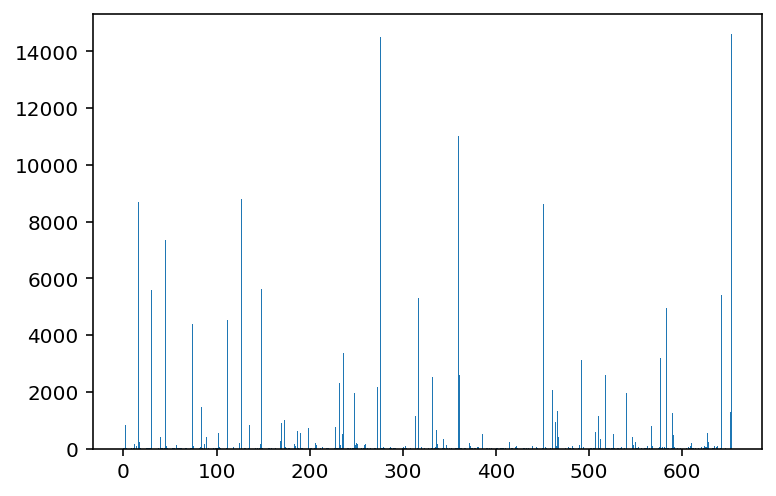

[641, 373, 136, 342, 537, 636, 70, 398, 249, 450, 156, 633, 483, 290, 58, 370, 256, 9, 205, 258, 219, 153, 241, 539, 57, 73, 103, 548, 598, 23, 41, 186, 300, 28, 338, 600, 87, 347, 513, 335, 207, 14, 260, 121, 465, 163, 453, 456, 637, 324, 47, 259, 196, 570, 609, 482, 571, 234, 623, 557, 316, 592, 93, 478, 327, 240, 528, 49, 568, 53, 607, 475, 479, 625, 6, 185, 638, 251, 197, 271, 353, 426, 12, 350, 584, 586, 34, 226, 581, 298, 439, 490, 150, 239, 46, 369, 438, 632, 614, 59, 634, 320, 535, 516, 305, 214, 289, 303, 355, 400, 402, 487, 301, 354, 118, 470, 363, 485, 423, 175, 270, 279, 435, 443, 445, 378, 562, 630, 536, 184, 362, 366, 262, 210, 7, 561, 629, 343, 269, 252, 15, 217, 275, 514, 515, 134, 36, 133, 414, 285, 596, 225, 371, 31, 616, 412, 502, 380, 266, 193, 192, 203, 20, 635, 10, 310, 352, 580, 504, 32, 204, 60, 574, 611, 411, 503, 137, 519, 304, 486, 576, 572, 0, 104, 11, 377, 231, 357, 348, 3, 505, 506, 19, 48, 413, 5, 511, 602, 351, 8, 447, 444, 458, 525, 589, 142, 268, 247, 

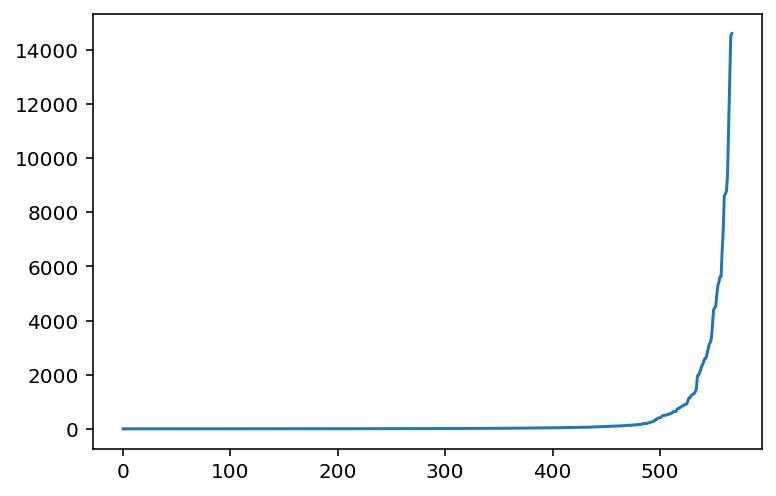

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

outputcnt = Counter(output)
plt.bar(outputcnt.keys(), outputcnt.values())
plt.show()

function_like_array=[]
for val in outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)



outliers = []

for i in outputcnt.keys():
    if outputcnt[i] < 160:
        outliers.append(i)

print(outliers)
print(len(outliers))


In [ ]:
#Because I don't want to mess up my inputs and outputs, I test their lengths before and after the outlier filtering.
assert(len(input) == len(output))

newinput=[]
newoutput=[]

for i in range(len(output)):
    if(output[i] not in outliers):
        newinput.append(input[i])
        newoutput.append(output[i])

input = newinput
output = newoutput

assert(len(input) == len(output))

In [ ]:
#However, this outlier filtering made things complicated. Now I have to make a new mapper, so that i won't end up with output classes containing 0 elements.

mapper_list = [] #Idx of the mapper list is the new value, the element is the old value.
new_output_elements = set(output)

for i in new_output_elements:
    mapper_list.append(i)

newoutput = []

for i in output:
    newoutput.append(mapper_list.index(i))

output = newoutput

In [ ]:
#Reshaping the input data to be compatible with LSTMs and normalizing it in the hope of better learning.

input = np.reshape(np.asarray(input), (len(input), SLICE_LEN, 1))
output = to_categorical(output)

input=np.asarray(input) / float(len(mapper))
output=np.asarray(output)

# MODEL TRAINING SECTION

In [ ]:
MODEL_NAME = "guitarmodel14"

MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves"

TBPATH = "/content/tblogs/"+MODEL_NAME

In [ ]:
#Before creating the neural network, I define some important callbacks

tb = TensorBoard(log_dir = TBPATH, write_images=True, histogram_freq=1)

plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)

es = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True, verbose=1)

callbacks = [plateau, es, tb]



In [ ]:
from keras.regularizers import l1_l2
from keras.layers import Dropout

In [ ]:
#I create the neural network model here.

model = Sequential()
model.add(LSTM(32, input_shape=(input.shape[1], input.shape[2])))
model.add(Dense(output.shape[1], activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(input, output, epochs=10000, batch_size=16, validation_split=0.2, callbacks=callbacks)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

Epoch 1/10000
10598/10598 [==============================] - 45s 4ms/step - loss: 3.6858 - accuracy: 0.1073 - val_loss: 3.4616 - val_accuracy: 0.1272
Epoch 2/10000
10598/10598 [==============================] - 43s 4ms/step - loss: 3.4490 - accuracy: 0.1512 - val_loss: 3.4459 - val_accuracy: 0.1425
Epoch 3/10000
10598/10598 [==============================] - 43s 4ms/step - loss: 3.3239 - accuracy: 0.1829 - val_loss: 3.4021 - val_accuracy: 0.1769
Epoch 4/10000
10598/10598 [==============================] - 43s 4ms/step - loss: 3.1854 - accuracy: 0.2188 - val_loss: 3.2746 - val_accuracy: 0.1988
Epoch 5/10000
10598/10598 [==============================] - 43s 4ms/step - loss: 3.0449 - accuracy: 0.2513 - val_loss: 3.1931 - val_accuracy: 0.2265
Epoch 6/10000
10598/10598 [==============================] - 42s 4ms/step - loss: 2.9238 - accuracy: 0.2783 - val_loss: 3.1323 - val_accuracy: 0.2436
Epoch 7/10000
10598/10598 [==============================] - 42s 4ms/step - loss: 2.8141 - accuracy:

In [ ]:
model.fit(input, output, epochs=10000, batch_size=16, validation_split=0.2, callbacks=callbacks)

In [ ]:
#I use the TensorBoard here

%tensorboard --logdir="/content/tblogs/guitarmodel1" #TODO FIX THIS TO BE A VARIABLE

# INFERENCE AND POSTPROCESSING SECTION

In [ ]:
def map_outlier_filtered_elements_to_old_value(value, mapperlist):
    return mapperlist[value]

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    preds = np.squeeze(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_notes(model, network_input, mapper, mapperlist = None, temp=1.0):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))

        prediction = model.predict(prediction_input, verbose=0)

        #prediction = sample(prediction, temp)
        index = sample(prediction, temp)

        #index = np.argmax(prediction)
        if mapperlist is not None: #Idx of the mapper list is the new value, the element is the old value. This is used when I filter for outliers.
            index=mapperlist[index]

        result = get_key_from_value(index, mapper)
        prediction_output.append(result)

        pattern = np.append(pattern, index/float(len(mapper)))

        pattern = pattern[1:len(pattern)]

    return prediction_output

In [ ]:
generated_outputs=[]

temperatures = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]

# DO NOT FORGET, IMPORTANT: When using outlier filtering, DO NOT FORGET to use the mapperlist parameter!!

for temp in tqdm(temperatures):
    generated_outputs.append(generate_notes(model, input, mapper, temp = temp))

100%|██████████| 6/6 [01:29<00:00, 14.85s/it]


In [ ]:
for out in generated_outputs:
    print(out)

['E3', 'E3', 'E4', 'E4', 'E2', 'E4', 'E4', 'E3', 'E3', 'E4', 'E4', 'B3', 'B3', 'A4', 'A3', 'A2', 'A3', 'A2', 'B3', 'B3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'C#3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B4', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'F#3', 'E3', 'B3', 'B3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'C#3', 'B3', 'B2', 'B2', 'B2', 'B2', 'B3', 'A3', 'B2', 'B2', 'B3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'C3', 'B3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B-2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B3', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2', 'B2',

In [ ]:
from music21 import stream

STARTING_OFFSET = 0

OUTPUT_PATH = "/content/drive/MyDrive/MLFolder/Onlab/Outputs/"

for i, out in enumerate(generated_outputs):
    create_midi_without_durations(out, target_instrument = instrument.ElectricBass(), filename = OUTPUT_PATH + MODEL_NAME + f'{i+STARTING_OFFSET}.mid')

# DEBUG SECTION

In [ ]:
#This is a debug cell, with a lot of prints:

print(mapper)
print(len(mapper))

print(input[0])

print(input.shape)
print(output.shape)


{'<music21.chord.Chord A2 A3 E3>': 0, '<music21.chord.Chord A2 A3>': 1, '<music21.chord.Chord A2 D2>': 2, '<music21.chord.Chord A2 D3 A3 D4>': 3, '<music21.chord.Chord A2 D3 G3>': 4, '<music21.chord.Chord A2 D3>': 5, '<music21.chord.Chord A2 E2>': 6, '<music21.chord.Chord A2 E3 A3 B3>': 7, '<music21.chord.Chord A2 E3 A3 C4 E4 A4>': 8, '<music21.chord.Chord A2 E3 A3 C4 E4>': 9, '<music21.chord.Chord A2 E3 A3 C4>': 10, '<music21.chord.Chord A2 E3 A3 E2>': 11, '<music21.chord.Chord A2 E3 A3>': 12, '<music21.chord.Chord A2 E3 B3>': 13, '<music21.chord.Chord A2 E3>': 14, '<music21.chord.Chord A2 G3>': 15, '<music21.chord.Chord A2>': 16, '<music21.chord.Chord A3 A2>': 17, '<music21.chord.Chord A3 A3 A4>': 18, '<music21.chord.Chord A3 A4 E3 E4 D4 D5>': 19, '<music21.chord.Chord A3 A4>': 20, '<music21.chord.Chord A3 B3 E4>': 21, '<music21.chord.Chord A3 B3>': 22, '<music21.chord.Chord A3 C#3>': 23, '<music21.chord.Chord A3 C3>': 24, '<music21.chord.Chord A3 C4>': 25, '<music21.chord.Chord A3 D

In [ ]:
debugarray = []
for i in midiparts:
    debugarray.append(i.instrument)

print(set(debugarray))

{'Electric Organ', 'Xylophone', 'Celesta', 'Viola', 'Electric Bass', 'Sampler', 'Brass', 'Acoustic Guitar', 'Voice', 'Electric Guitar', 'Acoustic Bass', 'Vibraphone', 'Accordion', 'Piano', 'StringInstrument', 'Violoncello'}
